In [2]:
# import packages 
import numpy as np
from numpy import genfromtxt
import seaborn as sns
import pandas as pd
import random
from matplotlib import pyplot as plt

In [3]:
# where layer_lengths[0] = # input neurons
# returns dict 'params' containing all weight matrices and bias vectors of right size
def initialize_parameters(layer_lengths):
    params = {}
    for layer in range(len(layer_lengths) - 1):
        params["W" + str(layer + 1)] = 0.001 * np.random.randn(layer_lengths[layer + 1], layer_lengths[layer])
        params["b" + str(layer + 1)] = np.zeros(((layer_lengths[layer + 1]),1))
    return params

In [4]:
# define activation functions
def relu(x):
    zeros = np.multiply(0, x)
    bool_array = np.greater(x, zeros)
    int_array = bool_array.astype(int)
    relu_x = np.multiply(int_array, x)
    return relu_x

def leaky_relu(x):
    zeros = np.multiply(0, x)
    bool_array = np.greater(x, zeros)
    int_array = bool_array.astype(int)
    int_array = np.multiply(1.01, int_array)
    int_array = np.subtract(int_array, 0.01)
    relu_x = np.multiply(int_array, x)
    return relu_x

def sigmoid(x):
    return 1 / (1 + np.exp(np.dot(-1, x)))

def tanh(x):
    return (np.exp(x) - np.exp(np.dot(-1, x))) / (np.exp(x) + np.exp(np.dot(-1, x)))

In [5]:
# define forward propagation 
# takes in X (size: input_neurons x training_examples), params dict, and activations list
# returns y_pred (size: output_neurons x training_examples), 
#     dict 'cache' containing Z (activations) and A (after applying activation function) for each layer 
def forward_prop(X, params, activations):
    y_pred = X
    cache = {}
    cache["A0"] = np.asarray(X)
    for layer in range(len(activations)):
        y_pred = np.dot(params["W" + str(layer + 1)], y_pred) + params["b" + str(layer + 1)]
        cache["Z" + str(layer + 1)] = y_pred
        activation = activations[layer]
        if activation == 'linear':
            pass
        elif activation == 'relu':
            y_pred = relu(y_pred)
        elif activation == 'leaky_relu':
            y_pred = leaky_relu(y_pred)
        elif activation == 'sigmoid':
            y_pred = sigmoid(y_pred)
        elif activation == 'tanh':
            y_pred = tanh(y_pred)
        else:
            print(f'Activation for layer {layer + 1} ({activation}) is not supported.')
            continue
        cache["A" + str(layer + 1)] = y_pred
    return cache, y_pred

In [6]:
# compute cost 
def compute_cost(y_pred, y, cost_function, epsilon = 1e-8):
    y = np.asarray(y)
    y_pred = np.asarray(y_pred)
    cost = None
    if len(y.shape) <= 1:
        m = 1
    else:
        m = y.shape[1]
    if cost_function == 'L2':
        cost = (1 / (2*m)) * np.sum(np.square(np.subtract(y_pred, y)))
    elif cost_function == 'cross_entropy':
        cost = (-1 / m) * np.sum((y * np.log(y_pred + epsilon)) + (np.subtract(1, y) * np.log(np.subtract(1, y_pred) + epsilon)))
    else:
        print(f'Cost function "{cost_function}" is not supported.')
    return cost

In [7]:
# define derivative of activation functions
def relu_prime(x):
    zeros = np.multiply(0, x)
    bool_array = np.greater(x, zeros)
    int_array = bool_array.astype(int)
    return int_array

def leaky_relu_prime(x):
    leaky = np.multiply(0.01, x)
    bool_array = np.greater(x, leaky)
    int_array = bool_array.astype(int)
    return int_array

def sigmoid_prime(x):
    return np.multiply(sigmoid(x), np.subtract(1, sigmoid(x)))

def tanh_prime(x):
    return np.subtract(1, np.square(tanh(x)))

In [8]:
# define backpropagation
# returns dict 'grads' containing gradients for each weight matrix and bias vector 
#     (contains derivative of cost wrt these parameters)
def backward_prop(params, cache, activations, y, cost_function):
    grads = {}
    num_layers = len(activations)
    layers = np.arange(num_layers)
    reversed_layers = np.flipud(layers)
    # starts with final layer, works backward
    for layer in reversed_layers:
        activation = activations[layer]
        
        # output layer
        if layer == (num_layers - 1):
            if len(y.shape) <= 1:
                m = 1
            else:
                m = y.shape[1]
            # compute dA (not stored)
            if cost_function == 'L2':
                dA_L = (1 / m) * (cache["A" + str(layer + 1)] - y)
            elif cost_function == 'cross_entropy':
                dA_L = (1 / m) * (np.subtract(np.divide(np.subtract(1, y), np.subtract(1, cache["A" + str(layer + 1)])), 
                                              np.divide(y, cache["A" + str(layer + 1)])))
            # compute dZ (stored in grads)
            if activation == 'linear':
                grads["dZ" + str(layer + 1)] = dA_L
                grads["dW" + str(layer + 1)] = np.dot(grads["dZ" + str(layer + 1)],
                                                      cache["A" + str(layer)].T)
            elif activation == 'relu':
                grads["dZ" + str(layer + 1)] = np.multiply(dA_L, relu_prime(cache["Z" + str(layer + 1)]))
            elif activation == 'leaky_relu':
                grads["dZ" + str(layer + 1)] = np.multiply(dA_L, leaky_relu_prime(cache["Z" + str(layer + 1)]))
            elif activation == 'sigmoid':
                grads["dZ" + str(layer + 1)] = np.multiply(dA_L, sigmoid_prime(cache["Z" + str(layer + 1)]))
            elif activation == 'tanh':
                grads["dZ" + str(layer + 1)] = np.multiply(dA_L, tanh_prime(cache["Z" + str(layer + 1)]))
            else:
                print(f'Activation for layer {layer + 1} ({activation}) is not supported.')
                break
        
        # every layer after output layer
        else:
            # compute dZ
            if activation == 'linear':
                grads["dZ" + str(layer + 1)] = np.dot(params["W" + str(layer + 2)].T, grads["dZ" + str(layer + 2)])
            elif activation == 'relu':
                grads["dZ" + str(layer + 1)] = np.multiply(np.dot(params["W" + str(layer + 2)].T, grads["dZ" + str(layer + 2)]), 
                                                           relu_prime(cache["Z" + str(layer + 1)]))
            elif activation == 'leaky_relu':
                grads["dZ" + str(layer + 1)] = np.multiply(np.dot(params["W" + str(layer + 2)].T, grads["dZ" + str(layer + 2)]), 
                                                           leaky_relu_prime(cache["Z" + str(layer + 1)]))
            elif activation == 'sigmoid':
                grads["dZ" + str(layer + 1)] = np.multiply(np.dot(params["W" + str(layer + 2)].T, grads["dZ" + str(layer + 2)]), 
                                                           sigmoid_prime(cache["Z" + str(layer + 1)]))
            elif activation == 'tanh':
                grads["dZ" + str(layer + 1)] = np.multiply(np.dot(params["W" + str(layer + 2)].T, grads["dZ" + str(layer + 2)]), 
                                                           tanh_prime(cache["Z" + str(layer + 1)]))
            else:
                print(f'Activation for layer {layers - layer} ({activation}) is not supported.')
                break
        # compute dW, db (stored in grads)
        grads["dW" + str(layer + 1)] = np.dot(grads["dZ" + str(layer + 1)], cache["A" + str(layer)].T)
        grads["db" + str(layer + 1)] = np.sum(grads["dZ" + str(layer + 1)], axis=1, keepdims=True)
    return grads
        

In [118]:
# used when gradient checking
def array_to_vector(arr):
    arr_temp = arr.copy()
    vec_temp = np.reshape(arr_temp, arr_temp.size)
    return vec_temp

In [119]:
# used when gradient checking
def vector_to_array(vec, arr_shape):
    vec_temp = vec.copy()
    arr_temp = np.reshape(vec_temp, (arr_shape[0], arr_shape[1]))
    return arr_temp

In [122]:
# gradient checking for W1
# gradient checking for other parameters can be done similarly
params_testing = initialize_parameters([5, 3, 1])
X = [[0.5], [1], [2], [3], [4]]
y = np.asarray([0.3])
activations = ['tanh', 'sigmoid']
W1_vec = array_to_vector(params_testing["W1"])
dW1_check = []
epsilon = 1e-5
for i in range(W1_vec.size):
    print('###############################')
    print(f'element {i}')
    W1_vec_temp = W1_vec.copy()
    params_temp_upper = params_testing.copy()
    W1_vec_upper = W1_vec_temp.copy()
    W1_vec_upper[i] += epsilon
    W1_arr_upper = vector_to_array(W1_vec_upper, (3, 5))
    params_temp_upper["W1"] = W1_arr_upper
    print(f'upper params {params_temp_upper}')
    
    W1_vec_temp = W1_vec.copy()
    params_temp_lower = params_testing.copy()
    W1_vec_lower = W1_vec_temp.copy()
    W1_vec_lower[i] -= epsilon
    W1_arr_lower = vector_to_array(W1_vec_lower, (3, 5))
    params_temp_lower["W1"] = W1_arr_lower
    print(f'lower params {params_temp_lower}')
    
    cache_upper, y_pred_upper = forward_prop(X, params=params_temp_upper, activations=activations)
    cache_lower, y_pred_lower = forward_prop(X, params=params_temp_lower, activations=activations)
    print(f'upper cache: {cache_upper}')
    print(f'lower cache: {cache_lower}')
    print(f'upper y_pred: {y_pred_upper}')
    print(f'lower y_pred: {y_pred_lower}')
    cost_upper = compute_cost(y_pred_upper, y, 'L2')
    cost_lower = compute_cost(y_pred_lower, y, 'L2')
    print(f'upper cost: {cost_upper}')
    print(f'lower cost: {cost_lower}')
    
    dw = (cost_upper - cost_lower) / (2 * epsilon)
    print(f'dW1_{str(i)}: {dw}')
    dW1_check.append(dw)
dW1_check

###############################
element 0
upper params {'W1': array([[-9.11200313e-04, -5.27717321e-04, -2.54167022e-05,
        -1.67495649e-03,  4.12180599e-04],
       [ 4.96914982e-04, -6.60446731e-04,  3.39791365e-04,
         6.20921301e-04,  1.36041977e-03],
       [-1.41411166e-04,  2.61649941e-04,  1.47047063e-03,
         4.36290835e-05,  1.02168673e-04]]), 'b1': array([[0.],
       [0.],
       [0.]]), 'W2': array([[-5.75092476e-04,  5.13673840e-05, -2.22392568e-04]]), 'b2': array([[0.]])}
lower params {'W1': array([[-9.31200313e-04, -5.27717321e-04, -2.54167022e-05,
        -1.67495649e-03,  4.12180599e-04],
       [ 4.96914982e-04, -6.60446731e-04,  3.39791365e-04,
         6.20921301e-04,  1.36041977e-03],
       [-1.41411166e-04,  2.61649941e-04,  1.47047063e-03,
         4.36290835e-05,  1.02168673e-04]]), 'b1': array([[0.],
       [0.],
       [0.]]), 'W2': array([[-5.75092476e-04,  5.13673840e-05, -2.22392568e-04]]), 'b2': array([[0.]])}
upper cache: {'A0': array([[0.

[-1.4377069847137934e-05,
 -2.875413952080352e-05,
 -5.750827886813469e-05,
 -8.626241734810412e-05,
 -0.00011501655565460121,
 1.284115001831676e-06,
 2.568229136301614e-06,
 5.136457058296795e-06,
 7.704686194598409e-06,
 1.027291411659359e-05,
 -5.559753872563799e-06,
 -1.111950687776586e-05,
 -2.2239016010672238e-05,
 -3.3358524102744536e-05,
 -4.447803098051039e-05]

In [125]:
# find dW1 output using backprop function
cache, y_pred = forward_prop(X, params_testing, activations)
grads = backward_prop(params_testing, cache, activations, y, 'L2')
grads

{'dZ2': array([[0.05000013]]),
 'dW2': array([[-0.00022076,  0.0003786 ,  0.00018357]]),
 'db2': array([[0.05000013]]),
 'dZ1': array([[-2.87541392e-05],
        [ 2.56822873e-06],
        [-1.11195079e-05]]),
 'dW1': array([[-1.43770696e-05, -2.87541392e-05, -5.75082783e-05,
         -8.62624175e-05, -1.15016557e-04],
        [ 1.28411436e-06,  2.56822873e-06,  5.13645745e-06,
          7.70468618e-06,  1.02729149e-05],
        [-5.55975394e-06, -1.11195079e-05, -2.22390158e-05,
         -3.33585236e-05, -4.44780315e-05]]),
 'db1': array([[-2.87541392e-05],
        [ 2.56822873e-06],
        [-1.11195079e-05]])}

In [127]:
# check if dW1 computed explicitly and dW1 using backprop are similar
# error should be less than ~1e-7 if implemented properly
dW1_check = np.asarray(dW1_check)
dW1_real = grads['dW1']
dW1_real_vec = array_to_vector(dW1_real)
error = (np.linalg.norm(np.subtract(dW1_check, dW1_real_vec)) / 
         max(np.linalg.norm(dW1_check), np.linalg.norm(dW1_real_vec)))
print(f'error: {error}')

1.2334024228968978e-08


In [9]:
# update params (e.g. W1 := W1 - learning_rate * dW1)
# may add optimizers in future (ex. Adam, RMSprop)
def update_params(params, grads, learning_rate):
    for i, j in enumerate(params):
        params[j] -= np.multiply(learning_rate, grads['d' + j])
    return params

In [10]:
# create class NeuralNetwork 
class NeuralNetwork:
    
    def __init__(self, X_train, y_train, X_val, y_val, layer_lengths, activations):
        self.X = np.asarray(X_train)
        self.y = np.asarray(y_train)
        self.X_val = np.asarray(X_val)
        self.y_val = np.asarray(y_val)
        if len(layer_lengths) != (len(activations) + 1):
            raise ValueError(f'# of layers {len(layer_lengths)} should be one more \
                             than number of activation functions {len(activations)}.')
        if self.X.shape[0] != layer_lengths[0]:
            raise ValueError(f'Number of input neurons {layer_lengths[0]} \
                             does not match rows of X {X.shape[0]}.')
        self.layer_lengths = layer_lengths
        self.activations = activations
        self.params = initialize_parameters(layer_lengths)
        
        
    def predict_proba(self, X, params=None, activations=None):
        if params == None:
            if activations == None:
                cache_predict, y_pred = forward_prop(X, self.params, self.activations)
            else:
                cache_predict, y_pred = forward_prop(X, self.params, activations)
        else:
            if activations == None:
                cache_predict, y_pred = forward_prop(X, params, self.activations)
            else:
                cache_predict, y_pred = forward_prop(X, params, activations)
        return y_pred
    
    
    def predict(self, X, params=None, activations=None):
        if ((params==None) and (activations==None)):
            y_pred_prob = self.predict_proba(X, self.params, self.activations)
            y_pred_list = np.argmax(y_pred_prob, axis=0)
            return y_pred_list
        else:
            y_pred_prob = self.predict_proba(X, params, activations)
            y_pred_list = np.argmax(y_pred_prob, axis=0)
            return y_pred_list
    
    
    def compute_accuracy(self, y_pred_list, y, verbose=True):
        y_pred_list = np.asarray(y_pred_list)
        y = np.asarray(y)
        count = 0
        success = 0
        if len(y_pred_list) != y.shape[1]:
            print(f'Lists do not match in length.')
            return None
        for i in range(len(y_pred_list)):
            count += 1
            success += y[y_pred_list[i], i]
        if verbose:
            print(success, count)
        return success / count
    
    
    def train(self, cost_function, learning_rate, epochs, minibatch_size=None, 
              continue_training=False, params=None, cost_history=None, val_cost_history=None):
        self.cost_function = cost_function
        self.learning_rate = learning_rate
        if not continue_training:
            self.cost_history = []
            self.val_cost_history = []
        else:
            self.cost_history = cost_history
            self.val_cost_history = val_cost_history
            self.params = params
    
        # minibatch learning
        if minibatch_size is not None:
            batches = (self.X.shape[1] // minibatch_size) + 1
            print('Epoch: ', end='')
            for i in range(epochs):
                print(f'{i}, ', end='')
                for batch_num in range(batches - 1):
                    X_batch = self.X[:, (batch_num * minibatch_size) : ((batch_num + 1) * minibatch_size)]
                    y_batch = self.y[:, (batch_num * minibatch_size) : ((batch_num + 1) * minibatch_size)]
                    cache_batch, y_pred_batch = forward_prop(X_batch, self.params, self.activations)
                    grads = backward_prop(self.params, cache_batch, self.activations, y_batch, self.cost_function)
                    self.params = update_params(self.params, grads, self.learning_rate)

                X_batch = self.X[:, ((batches - 1) * minibatch_size) :]
                y_batch = self.y[:, ((batches - 1) * minibatch_size) :]
                cache_batch, y_pred_batch = forward_prop(X_batch, self.params, self.activations)
                grads = backward_prop(self.params, cache_batch, self.activations, y_batch, self.cost_function)
                self.params = update_params(self.params, grads, self.learning_rate)

                cache, y_pred = forward_prop(self.X, self.params, self.activations)
                cost = compute_cost(y_pred, self.y, self.cost_function)
                self.cost_history.append(cost)
                y_val_pred = self.predict_proba(self.X_val, self.params, self.activations)
                val_cost = compute_cost(y_val_pred, self.y_val, self.cost_function)
                self.val_cost_history.append(val_cost)
        else:
            # not using minibatch
            print('Epoch: ', end='')
            for i in range(epochs):
                print(f'{i}, ')
                cache, y_pred = forward_prop(self.X, self.params, self.activations)
                cost = compute_cost(y_pred, self.y, self.cost_function)
                self.cost_history.append(cost)
                grads = backward_prop(self.params, cache, self.activations, y, self.cost_function)
                self.params = update_params(self.params, grads, self.learning_rate)
                y_val_pred = self.predict_proba(self.X_val, self.params, self.activations)
                val_cost = compute_cost(y_val_pred, self.y_val, self.cost_function)
                self.val_cost_history.append(val_cost)

In [12]:
# read in training data (first col is digit, remaining 784 cols are pixel values)
X_train = pd.read_csv('mnist_train.csv')

In [13]:
X_train.shape

(59999, 785)

In [14]:
y_train = X_train.iloc[:,0]
X_train = X_train.iloc[:,1:]
print(X_train.shape)
print(y_train.shape)

(59999, 784)
(59999,)


In [15]:
X_test = pd.read_csv('mnist_test.csv', index_col=False)
print(X_test.shape)
y_test = X_test.iloc[:,0]
X_test = X_test.iloc[:,1:]
print(X_test.shape)
print(y_test.shape)

(9999, 785)
(9999, 784)
(9999,)


In [16]:
def train_test_split(X, y, test_prop):
    test_num = int(test_prop * X.shape[0])
    test_list = random.sample(set(np.arange(X.shape[0])), test_num)
    print(f'test list length: {len(test_list)}')
    print(f'test list first 20: {list(test_list)[:20]}')
    X_test = X.loc[test_list, :]
    y_test = y.loc[test_list]
    
    train_list = set(np.arange(X.shape[0])).difference(set(test_list))
    if len(train_list.intersection(test_list)) != 0:
        print('Error!')
        return None
    print(f'train list length: {len(train_list)}')
    print(f'train list first 20: {list(train_list)[:20]}')
    X_train = X.loc[train_list, :]
    y_train = y.loc[train_list]
    
    return X_train, y_train, X_test, y_test

In [17]:
X_train, y_train, X_val, y_val = train_test_split(X_train, y_train, test_prop=0.2)

test list length: 11999
test list first 20: [18836, 42998, 11930, 46827, 1905, 13349, 21721, 53433, 16536, 24946, 16360, 124, 49263, 57890, 197, 17094, 10779, 38669, 52040, 26132]
train list length: 48000
train list first 20: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]


In [18]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
y_train = y_train.reshape((48000,1))
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)
y_val = y_val.reshape(11999,1)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(48000, 784)
(48000, 1)
(11999, 784)
(11999, 1)


In [19]:
# for this model, we put individual training examples in columns (size: 784 x num_examples)

X_train = X_train.T
X_val = X_val.T
X_test = X_test.T
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(784, 48000)
(784, 11999)


In [20]:
print(y_train[:20])
y_train_df = pd.DataFrame(data=y_train)
y_train_df.columns = ['Label']
y_train_df = pd.get_dummies(y_train_df.Label)
print(y_train_df[:20])
print(y_train_df.shape)
print('####################')
print()

print(y_val.shape)
y_val_df = pd.DataFrame(data=y_val)
y_val_df.columns = ['Label']
y_val_df = pd.get_dummies(y_val_df.Label)
print(y_val_df.shape)
print(y_val[:20])
print(y_val_df[:20])
print('####################')
print()

print(y_test[:20])
y_test_df = pd.DataFrame(data=y_test)
y_test_df.columns = ['Label']
y_test_df = pd.get_dummies(y_test_df.Label)
print(y_test_df[:20])
print(y_test_df.shape)

(11999, 1)
(11999, 10)
[[0]
 [1]
 [9]
 [9]
 [6]
 [4]
 [2]
 [2]
 [7]
 [9]
 [2]
 [8]
 [2]
 [6]
 [3]
 [0]
 [9]
 [3]
 [3]
 [1]]
    0  1  2  3  4  5  6  7  8  9
0   1  0  0  0  0  0  0  0  0  0
1   0  1  0  0  0  0  0  0  0  0
2   0  0  0  0  0  0  0  0  0  1
3   0  0  0  0  0  0  0  0  0  1
4   0  0  0  0  0  0  1  0  0  0
5   0  0  0  0  1  0  0  0  0  0
6   0  0  1  0  0  0  0  0  0  0
7   0  0  1  0  0  0  0  0  0  0
8   0  0  0  0  0  0  0  1  0  0
9   0  0  0  0  0  0  0  0  0  1
10  0  0  1  0  0  0  0  0  0  0
11  0  0  0  0  0  0  0  0  1  0
12  0  0  1  0  0  0  0  0  0  0
13  0  0  0  0  0  0  1  0  0  0
14  0  0  0  1  0  0  0  0  0  0
15  1  0  0  0  0  0  0  0  0  0
16  0  0  0  0  0  0  0  0  0  1
17  0  0  0  1  0  0  0  0  0  0
18  0  0  0  1  0  0  0  0  0  0
19  0  1  0  0  0  0  0  0  0  0
[[0]
 [4]
 [1]
 [9]
 [2]
 [1]
 [3]
 [1]
 [4]
 [3]
 [5]
 [3]
 [1]
 [7]
 [2]
 [8]
 [6]
 [9]
 [4]
 [0]]
    0  1  2  3  4  5  6  7  8  9
0   1  0  0  0  0  0  0  0  0  0
1   0  0  0  0  

In [21]:
y_train = np.asarray(y_train_df)
y_val = np.asarray(y_val_df)
y_test = np.asarray(y_test_df)
y_train = y_train.T
y_val = y_val.T
y_test = y_test.T
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(10, 48000)
(10, 11999)


In [22]:
# start training

layer_lengths = [784, 1000, 1000, 10]
activations = ['relu', 'relu', 'sigmoid']
cost_function = 'cross_entropy'
learning_rate = 0.001
epochs = 5
minibatch_size = 256

digit_recognizer = NeuralNetwork(X_train, y_train, X_val, y_val, layer_lengths=layer_lengths, activations=activations)
digit_recognizer.train(cost_function=cost_function, learning_rate=learning_rate, epochs=epochs, minibatch_size=minibatch_size)


Epoch: 0, 1, 2, 3, 4, 

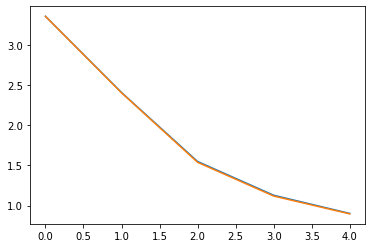

In [25]:
# plot training cost and val cost to avoid overfitting
plt.plot(digit_recognizer.cost_history)
plt.plot(digit_recognizer.val_cost_history)
plt.show()

Epoch: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

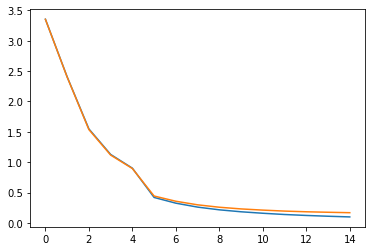

In [26]:
# continue training
epochs = 10
learning_rate = 0.005
params = digit_recognizer.params
cost_history = digit_recognizer.cost_history
val_cost_history = digit_recognizer.val_cost_history

digit_recognizer.train(cost_function=cost_function, learning_rate=learning_rate, epochs=epochs, minibatch_size=minibatch_size,
                      continue_training=True, params=params, cost_history=cost_history, val_cost_history=val_cost_history)
plt.plot(digit_recognizer.cost_history)
plt.plot(digit_recognizer.val_cost_history)
plt.show()

In [27]:
# check to make sure val accuracy is increasing
y_val_pred_list = digit_recognizer.predict(X_val, params=None, activations=None)
val_acc = digit_recognizer.compute_accuracy(y_val_pred_list, y_val)
print(val_acc)

11691 11999
0.9743311942661889


Epoch: 0, 1, 2, 3, 4, 

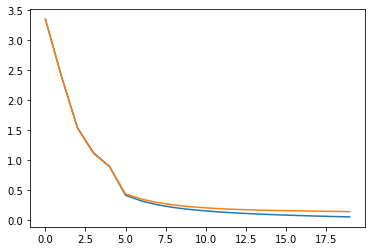

In [28]:
# continue training
epochs = 5

params = digit_recognizer.params
cost_history = digit_recognizer.cost_history
val_cost_history = digit_recognizer.val_cost_history
digit_recognizer.train(cost_function=cost_function, learning_rate=learning_rate, epochs=epochs, minibatch_size=minibatch_size,
                      continue_training=True, params=params, cost_history=cost_history, val_cost_history=val_cost_history)
plt.plot(digit_recognizer.cost_history)
plt.plot(digit_recognizer.val_cost_history)
plt.show()

In [29]:
# check to make sure val accuracy is increasing
y_val_pred_list = digit_recognizer.predict(X_val)
val_acc = digit_recognizer.compute_accuracy(y_val_pred_list, y_val)
print(val_acc)

11723 11999
0.9769980831735978


Epoch: 0, 1, 2, 3, 4, 

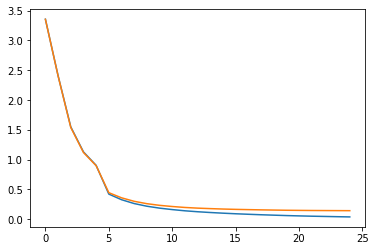

11734 11999
0.9779148262355196


In [30]:
# continue training
epochs = 5

params = digit_recognizer.params
cost_history = digit_recognizer.cost_history
val_cost_history = digit_recognizer.val_cost_history
digit_recognizer.train(cost_function=cost_function, learning_rate=learning_rate, epochs=epochs, minibatch_size=minibatch_size,
                      continue_training=True, params=params, cost_history=cost_history, val_cost_history=val_cost_history)
plt.plot(digit_recognizer.cost_history)
plt.plot(digit_recognizer.val_cost_history)
plt.show()

# check to make sure val accuracy is increasing
y_val_pred_list = digit_recognizer.predict(X_val)
val_acc = digit_recognizer.compute_accuracy(y_val_pred_list, y_val)
print(val_acc)

Epoch: 0, 1, 2, 3, 4, 

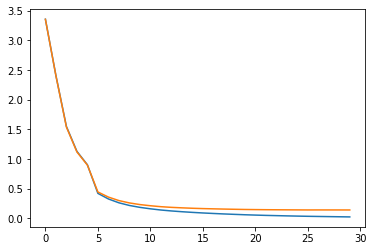

11754 11999
0.9795816318026502


In [31]:
# continue training
epochs = 5

params = digit_recognizer.params
cost_history = digit_recognizer.cost_history
val_cost_history = digit_recognizer.val_cost_history
digit_recognizer.train(cost_function=cost_function, learning_rate=learning_rate, epochs=epochs, minibatch_size=minibatch_size,
                      continue_training=True, params=params, cost_history=cost_history, val_cost_history=val_cost_history)
plt.plot(digit_recognizer.cost_history)
plt.plot(digit_recognizer.val_cost_history)
plt.show()

# check to make sure val accuracy is increasing
y_val_pred_list = digit_recognizer.predict(X_val)
val_acc = digit_recognizer.compute_accuracy(y_val_pred_list, y_val)
print(val_acc)

Epoch: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

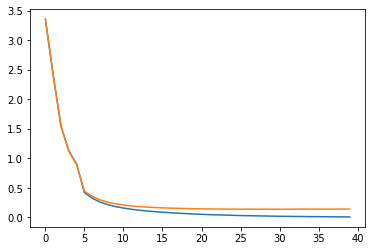

11782 11999
0.981915159596633


In [34]:
# continue training
epochs = 10

params = digit_recognizer.params
cost_history = digit_recognizer.cost_history
val_cost_history = digit_recognizer.val_cost_history
digit_recognizer.train(cost_function=cost_function, learning_rate=learning_rate, epochs=epochs, minibatch_size=minibatch_size,
                      continue_training=True, params=params, cost_history=cost_history, val_cost_history=val_cost_history)
plt.plot(digit_recognizer.cost_history)
plt.plot(digit_recognizer.val_cost_history)
plt.show()

# check to make sure val accuracy is increasing
y_val_pred_list = digit_recognizer.predict(X_val)
val_acc = digit_recognizer.compute_accuracy(y_val_pred_list, y_val)
print(val_acc)

In [35]:
# check training accuracy
y_train_pred_list = digit_recognizer.predict(X_train)
train_acc = digit_recognizer.compute_accuracy(y_train_pred_list, y_train)
print(train_acc)

47992 48000
0.9998333333333334


In [39]:
# check test accuracy
y_test_pred_list = digit_recognizer.predict(X_test)
test_acc = digit_recognizer.compute_accuracy(y_test_pred_list, y_test)
print(test_acc)

9812 9999
0.9812981298129813


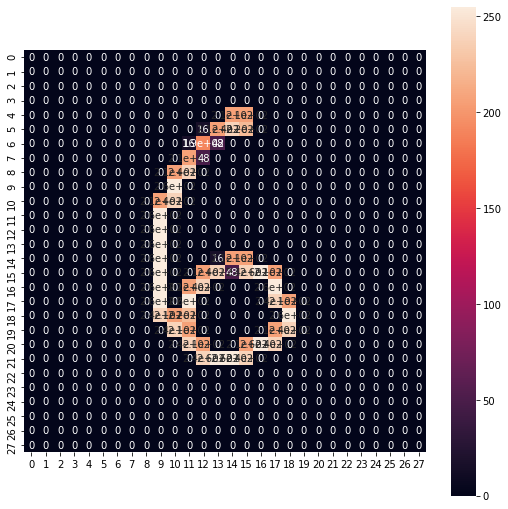

In [116]:
# start here when testing on new predictions
# make sure to convert your image to an array of values using digit_image_processor file

# read in your csv file
user_input = genfromtxt('test.csv', delimiter=',')

# plot heatmap as a sanity check 
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(user_input, annot=True, ax=ax, square=True)
plt.show()

In [117]:
# output prediction for your digit!

user_input = np.reshape(user_input, (784,1))
user_pred = int(digit_recognizer.predict(user_input))
print(f'My prediction is {user_pred}!')

My prediction is 6!
